In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset as BaseDataset
import torch
import albumentations as albu
import cv2
import h5py

In [77]:
DATA_DIR = './'
x_train_dir = os.path.join(DATA_DIR, '../../sample_valid_imgs')
y_train_dir = os.path.join(DATA_DIR, '../../sample_valid_masks')

x_valid_dir = os.path.join(DATA_DIR, '../../sample_valid_imgs')
y_valid_dir = os.path.join(DATA_DIR, '../../sample_valid_masks')

In [84]:
class HubMapDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'blood_vessel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
#         masks = [(mask == v) for v in self.class_values]
#         mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return self.images_fps[i], image, mask
        
    def __len__(self):
        return len(self.ids)

In [85]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [86]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)

def to_tensor(image, **kwargs):
  return torch.tensor(image, dtype=torch.float32)
  
def convert_to_grayscale(image, **kwargs):
  grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  max_grayscale_num = grayscale.max()
  min_grayscale_num = grayscale.min()
  grayscale = (grayscale-min_grayscale_num) / float(max_grayscale_num-min_grayscale_num)
  return grayscale
  
def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=convert_to_grayscale),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(512, 512, 3) torch.Size([512, 512]) (512, 512) torch.Size([512, 512])


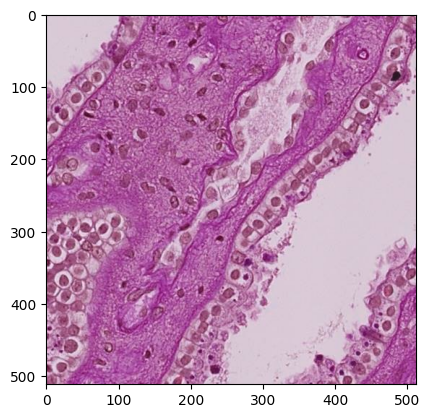

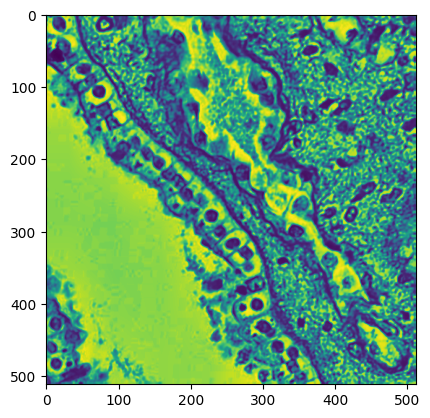

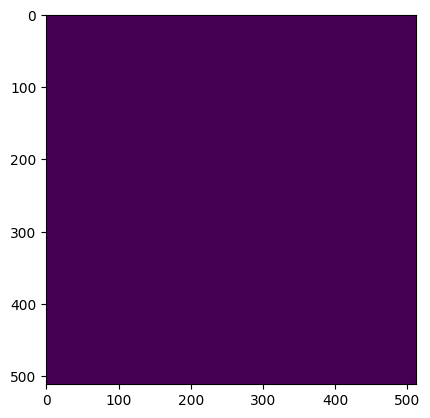

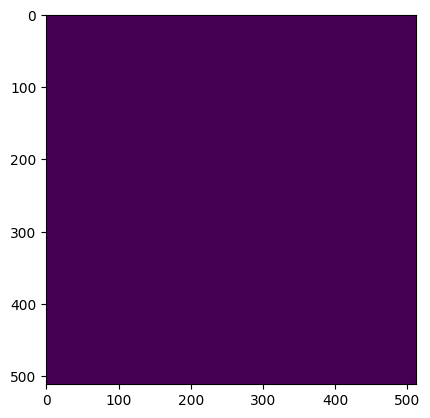

[0.         0.00416667 0.00833333 0.0125     0.01666667 0.02083333
 0.025      0.02916667 0.03333334 0.0375     0.04166667 0.04583333
 0.05       0.05416667 0.05833333 0.0625     0.06666667 0.07083333
 0.075      0.07916667 0.08333334 0.0875     0.09166667 0.09583333
 0.1        0.10416666 0.10833333 0.1125     0.11666667 0.12083333
 0.125      0.12916666 0.13333334 0.1375     0.14166667 0.14583333
 0.15       0.15416667 0.15833333 0.1625     0.16666667 0.17083333
 0.175      0.17916666 0.18333334 0.1875     0.19166666 0.19583334
 0.2        0.20416667 0.20833333 0.2125     0.21666667 0.22083333
 0.225      0.22916667 0.23333333 0.2375     0.24166666 0.24583334
 0.25       0.25416666 0.25833333 0.2625     0.26666668 0.27083334
 0.275      0.27916667 0.28333333 0.2875     0.29166666 0.29583332
 0.3        0.30416667 0.30833334 0.3125     0.31666666 0.32083333
 0.325      0.32916668 0.33333334 0.3375     0.34166667 0.34583333
 0.35       0.35416666 0.35833332 0.3625     0.36666667 0.3708

In [87]:
dataset = HubMapDataset(x_train_dir,
                        y_train_dir,
                        classes=['unlabelled', 'blood_vessel'])
dataset_with_aug_preproc = HubMapDataset(x_train_dir,
                                         y_train_dir,
                                         augmentation=get_training_augmentation(),
                                         preprocessing=get_preprocessing(),
                                         classes=['unlabelled', 'blood_vessel'])
_, img, mask = dataset[0]
_, img_preproc, mask_preproc = dataset_with_aug_preproc[0]
print(img.shape, img_preproc.shape, mask.shape, mask_preproc.shape)
plt.imshow(img)
plt.show()
plt.imshow(img_preproc)
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(mask_preproc)
plt.show()
print(np.unique(img_preproc), np.unique(mask_preproc))

In [106]:
# Make the directories if they don't exist
base_data_path = '../data/HubMap'
if not os.path.exists(base_data_path):
  os.mkdir(base_data_path)
if not os.path.exists(f'{base_data_path}/train_npz'):
  os.mkdir(f'{base_data_path}/train_npz')
if not os.path.exists(f'{base_data_path}/test_h5'):
  os.mkdir(f'{base_data_path}/test_h5')
if not os.path.exists(f'./lists/lists_HubMap'):
  os.mkdir(f'./lists/lists_HubMap')

In [102]:
train_dataset = HubMapDataset(x_train_dir,
                             y_train_dir,
                             augmentation=get_training_augmentation(),
                             preprocessing=get_preprocessing(),
                             classes=['unlabelled', 'blood_vessel'])
valid_dataset = HubMapDataset(x_valid_dir,
                             y_valid_dir,
                             preprocessing=get_preprocessing(),
                             classes=['unlabelled', 'blood_vessel'])
len(train_dataset), len(valid_dataset)

(3, 3)

In [103]:
os.listdir(f'{base_data_path}/train_npz')

[]

In [107]:
# Save the training data for trans unet
all_train_fids = []
for i in range(len(train_dataset)):
  fname, image, mask = train_dataset[i]
  fid = fname.split('/')[-1].split('.')[0]
  all_train_fids.append(fid)
  np.savez(f'{base_data_path}/train_npz/{fid}.npz', image=image, label=mask)
with open(f'./lists/lists_HubMap/train.txt', 'w') as f:
  for fid in all_train_fids:
    f.write(f'{fid}\n')

In [108]:
all_valid_fids = []
for i in range(len(valid_dataset)):
  fname, image, mask = valid_dataset[i]
  fid = fname.split('/')[-1].split('.')[0]
  all_valid_fids.append(fid)
  with h5py.File(f'{base_data_path}/test_h5/{fid}.npy.h5', 'w') as hf:
    hf.create_dataset('image', data=image)
    hf.create_dataset('label', data=mask)
with open(f'./lists/lists_HubMap/test.txt', 'w') as f:
  for fid in all_valid_fids:
    f.write(f'{fid}\n')